### Projet Monte Carlo - ABC for alpha-stable models
## Zakaria BOULIAIRE, Clémence CHEVRIER, Félix DE CHAMPS DE SAINT LEGER, Enzo LOUNES

## 1. Import des modules nécessaires

In [163]:
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import levy_stable
from scipy.stats import qmc
import seaborn as sns

On fixe la graine pour assurer la reproductibilité des résultats. 

In [164]:
np.random.seed(124)

Premièrement, regardons à quoi ressemble une distribution alpha-stable.

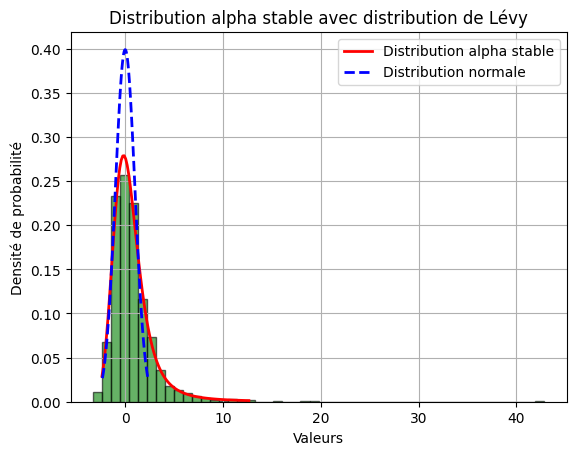

In [165]:
# Paramètres de la distribution alpha stable avec distribution de Lévy
alpha = 1.5  # Paramètre alpha (0 < alpha <= 2 pour la distribution de Lévy)
beta = 1   # Paramètre beta (-1 <= beta <= 1)
loc = 0.0    # Paramètre de position (moyenne de la distribution)
scale = 1.0  # Paramètre d'échelle (écart-type de la distribution)

# Génération d'échantillons à partir de la distribution alpha stable avec distribution de Lévy
n = 1000
samples = levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=n)

# Tracer l'histogramme des échantillons
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')

# Tracer la densité de probabilité théorique de la distribution alpha-stable
x_alpha = np.linspace(levy_stable.ppf(0.01, alpha, beta, loc=loc, scale=scale),
                levy_stable.ppf(0.99, alpha, beta, loc=loc, scale=scale), 100)
plt.plot(x_alpha, levy_stable.pdf(x_alpha, alpha, beta, loc=loc, scale=scale), 'r-', lw=2, label='Distribution alpha stable')

# Génération d'échantillons à partir d'une distribution normale pour la superposition
mu, sigma = loc, scale  # Utilisation des mêmes paramètres de position et d'échelle que la distribution alpha-stable
samples_norm = np.random.normal(mu, sigma, n)

# Tracer la densité de probabilité de la distribution normale
x_norm = np.linspace(norm.ppf(0.01, mu, sigma), norm.ppf(0.99, mu, sigma), 100)
plt.plot(x_norm, norm.pdf(x_norm, mu, sigma), 'b--', lw=2, label='Distribution normale')

plt.xlabel('Valeurs')
plt.ylabel('Densité de probabilité')
plt.title('Distribution alpha stable avec distribution de Lévy')
plt.grid(True)
plt.legend()
plt.show()


On voit que la distribution alpha-stable possède une asymétrie, et une queue plus lourde que la loi normale par exemple. 

## Question 1 : Implement the generator for alpha-stable distributions proposed in Appendix B, and explain why it is valid

# 1.1. Echantillonnage de W à partir d'une distribution exponentielle

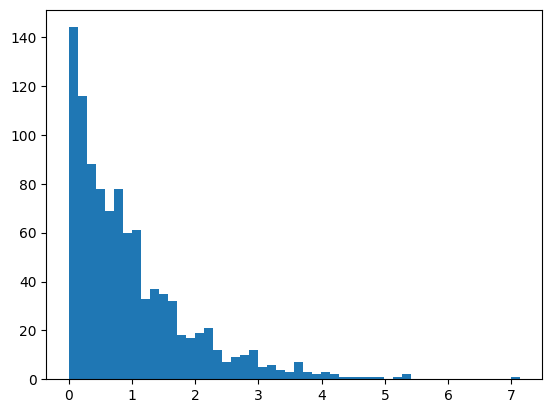

In [166]:
np.random.seed(124)
w = np.random.standard_exponential(size=n)
plt.hist(w, bins=50)
plt.show()

# 1.2. Echantillonnage de U à partir d'une distribution uniforme

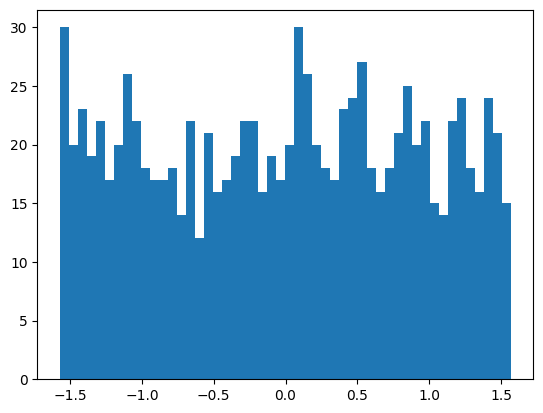

In [167]:
np.random.seed(124)
u = np.random.uniform(low = -np.pi/2, high = np.pi/2, size = n)
plt.hist(u, bins = 50)
plt.show()

# 1.3. Appliquer la transformation pour obtenir l'échantillon y_barre

In [168]:
np.random.seed(124)
u = np.random.uniform(low = -np.pi/2, high = np.pi/2, size = n)
w = np.random.standard_exponential(size=n)
n=1000
# On définit en premier lieu les S et B pour plus de clarté
def S(alpha, beta): 
    tan_term = np.tan(np.pi * alpha / 2)**2
    result = (1 + beta**2 * tan_term)**(1 / (2 * alpha))
    return result

def B(alpha, beta):
    tan_term = beta * np.tan(np.pi * alpha / 2)
    result = 1 / alpha * np.arctan(tan_term)
    return result

def calculate_y_barre(alpha, beta, u, w):
    if alpha != 1:
        S_alpha_beta = S(alpha, beta)
        B_alpha_beta = B(alpha, beta)
        sin_alpha = np.sin(alpha)
        cos_u = np.cos(u)
        term1 = S_alpha_beta * (sin_alpha * (u + B_alpha_beta))
        term2 = (cos_u) ** (1 / alpha)
        term3 = np.cos(u - alpha * (u + B_alpha_beta)) / w
        term4 = ((1 - alpha) / alpha)
        y_barre = (term1 / term2) * np.sign(term3)* (np.abs(term3) ** term4)
    else:
        term1 = (np.pi / 2 + beta * u) * np.tan(u)
        term2 = beta * np.log((np.pi / 2) * w * np.cos(u) / (np.pi / 2 + beta * u))
        y_barre = 2 / np.pi * (term1 - term2)
    return y_barre

print(calculate_y_barre(0.6,1,u,w))

[1.54635696e+00 5.37901294e+00 1.53462996e+00 1.21638391e+00
 2.39282986e+00 6.67839575e-01 3.28207636e+00 8.32124533e-01
 2.60243744e+00 4.63996180e+01 4.80735706e+00 8.41663505e-01
 2.14651837e+00 2.33028406e+02 3.60301168e+00 1.10675725e+00
 4.12906987e+00 1.08628913e+01 1.93599057e+00 1.69808258e+01
 2.60793353e+00 1.35363431e+00 7.24726263e+00 2.50046580e+00
 1.59010440e+00 2.40221624e+00 2.15931165e+00 6.00208562e+02
 7.62166232e+01 3.70278653e+02 8.47986798e-01 6.86315009e-01
 2.52802552e+00 1.71638065e+00 1.58660191e+00 9.39654614e+00
 1.08853266e+00 1.29615217e+00 3.55049464e+00 4.10126734e+01
 9.72978316e-01 4.42875038e+00 1.01667377e+00 1.53887809e+00
 2.87150947e+00 5.64288497e+01 2.95835130e+02 5.19699386e+00
 3.55665805e+00 5.93653780e+00 1.19894386e+00 9.94068784e+00
 8.69236674e-01 6.99758652e+00 6.80619653e-01 1.21978077e+01
 9.76146138e+00 7.61380327e+00 6.04345362e-01 9.08989664e+00
 1.12359002e+00 2.04171445e+00 6.73891588e+00 4.72083895e-01
 4.66235398e+00 1.253105

# 1.4. On applique une nouvelle transformation pour obtenir y

In [169]:
def transformation(alpha, beta, gamma, delta, u, w):
    y_barre = calculate_y_barre(alpha, beta, u, w)
    y = gamma * y_barre + delta
    return y

print(transformation(0.6,1,1,0,u,w))

[1.54635696e+00 5.37901294e+00 1.53462996e+00 1.21638391e+00
 2.39282986e+00 6.67839575e-01 3.28207636e+00 8.32124533e-01
 2.60243744e+00 4.63996180e+01 4.80735706e+00 8.41663505e-01
 2.14651837e+00 2.33028406e+02 3.60301168e+00 1.10675725e+00
 4.12906987e+00 1.08628913e+01 1.93599057e+00 1.69808258e+01
 2.60793353e+00 1.35363431e+00 7.24726263e+00 2.50046580e+00
 1.59010440e+00 2.40221624e+00 2.15931165e+00 6.00208562e+02
 7.62166232e+01 3.70278653e+02 8.47986798e-01 6.86315009e-01
 2.52802552e+00 1.71638065e+00 1.58660191e+00 9.39654614e+00
 1.08853266e+00 1.29615217e+00 3.55049464e+00 4.10126734e+01
 9.72978316e-01 4.42875038e+00 1.01667377e+00 1.53887809e+00
 2.87150947e+00 5.64288497e+01 2.95835130e+02 5.19699386e+00
 3.55665805e+00 5.93653780e+00 1.19894386e+00 9.94068784e+00
 8.69236674e-01 6.99758652e+00 6.80619653e-01 1.21978077e+01
 9.76146138e+00 7.61380327e+00 6.04345362e-01 9.08989664e+00
 1.12359002e+00 2.04171445e+00 6.73891588e+00 4.72083895e-01
 4.66235398e+00 1.253105

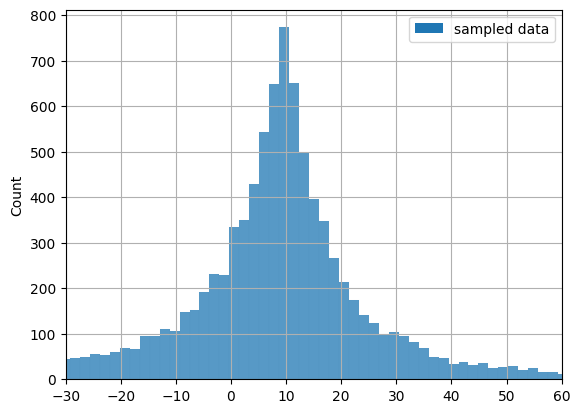

In [170]:
size=10000
u = np.random.uniform(low = -np.pi/2, high = np.pi/2, size = size)
w = np.random.standard_exponential(size=size)
x = transformation(1.7,0.9,10,10,u,w)
plt.hist(x, bins='auto', density=True,  label="sampled data")
sns.histplot(x, bins='auto')  # kde=True pour tracer la densité
plt.xlim(-30,60)
plt.grid()
plt.legend()
plt.show()

On voit bien les queues lourdes de distribution.

Ainsi, on a implémenté un générateur de distributions alpha-stables. Ce générateur est valide car les distributions alpha-stables sont caractérisées par leur fonction caractéristique puisqu'elles n'ont pas de closed form pour leur densité de probabilité. De plus, il y a une transformation qui invoque les variables auxiliaires U et W. Aussi, les sommes de variables aléatoires à queues lourdes tendent vers une distribution stable. Alors, si les paramètres alpha, beta, gamma, et delta sont dans leurs domaines respectifs, le générateur sera valide. 

## Question 2 : Explain how you could modify this generator to use RQMC sequences in order to approximate expectations under an alpha-stable distribution. Implement this for a certain function, and compare the resulting RQMC estimates with standard Monte Carlo estimates. (Careful: again, an alpha-stable distribution is typically heavy-tailed, make sure you choose a function whose variance is finite. . . ).

Pour modifier ce générateur pour utiliser des séquences QMC pour approximer les expectations avec une distribution alpha-stable, on peut d' abord chosir une séquence RQMC comme celle de Sobol, Halton ou Faure qui sont présentées dans l'article. Nous choisirons Sobol. En effet, ces séquences sont conçues pour être semi-aleatoires, et couvrir l'espace de manière plus optimale. Ensuite, on pourra modifier le générateur pour utiliser les valeurs de la séquence RQMC à la place des valeurs aléatoires précédemment utilisées. Alors, la convergence vers l'estimation de l'esperance sera plus rapide. Ensuite, on compare avec les estimations Monte Carlo standard.

Définition des fonctions de variance finie.

In [171]:
def f1(x):
    return x

def f2(x):
    return np.exp(-x**2)

def f3(x):
    return x**2 + x + 1

def f4(x):
    return np.sin(x)

Codons la partie sur la séquence de Sobol.

In [172]:
np.random.seed(124)
def sobol_sequence(n, d):
    sobol = qmc.Sobol(d)
    points = sobol.random(n)
    return points

print(sobol_sequence(2,3))

[[0.18302212 0.59235875 0.56476555]
 [0.60820294 0.22290411 0.27188488]]


Pour plus de clarté, regardons en dimension 2 quelle est la différence entre une génération aléatoire et quasi-aléatoire à l'aide de Sobol.

C:\Users\cleme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


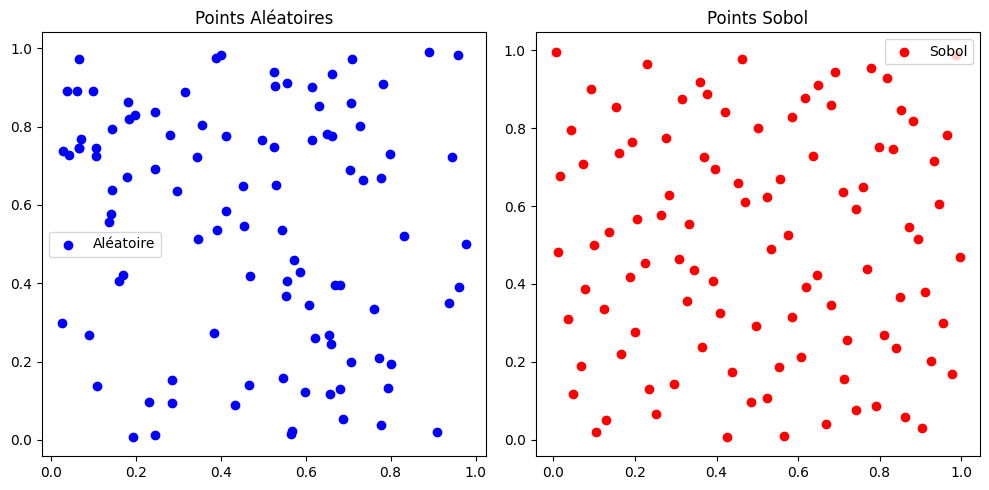

In [173]:
def random_points(n):
    return np.random.rand(n, 2)

def sobol_points(n):
    sobol = qmc.Sobol(2)
    points = sobol.random(n)
    return points

# Générer des points aléatoires
random = random_points(100)

# Générer des points avec la séquence Sobol
sobol = sobol_points(100)

# Créer un nouveau graphique avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Tracer les points aléatoires
axes[0].scatter(random[:, 0], random[:, 1], color='blue', label='Aléatoire')
axes[0].set_title('Points Aléatoires')

# Tracer les points avec la séquence Sobol
axes[1].scatter(sobol[:, 0], sobol[:, 1], color='red', label='Sobol')
axes[1].set_title('Points Sobol')

# Afficher la légende
for ax in axes:
    ax.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()

Codons une fonction pour estimer l'espérance avec Monte Carlo standard. 

In [174]:
def monte_carlo_estimate(f, n, alpha, beta, gamma, delta):
    w = np.random.exponential(scale=1, size=n)
    u = np.random.uniform(-np.pi/2, np.pi/2, size=n)
    y = levy_stable.rvs(alpha, beta, loc=delta, scale=gamma,size=n)
    return np.mean(f(y))


Maintenant, codons la fonction pour estimer l'espérance avec RQMC. Pour cela, on utilise Sobol pour créer des séquences semi-aléatoires.

In [175]:
def rqmc_estimate(f, n, alpha, beta, gamma, delta):
    d = 1  # Dimension de la séquence
    points = sobol_sequence(n, d)
    u = np.arccos(2 * points - 1) - np.pi/2  # Transformation pour obtenir u entre -pi/2 et pi/2
    w = -np.log(1 - points)  # Transformation pour obtenir w selon une distribution exponentielle
    y = levy_stable.rvs(alpha, beta, loc=delta, scale=gamma,size=n)
    return np.mean(f(y))

In [176]:
alpha = 0.6
beta = 1
gamma = 1
delta = 0

# Nombre d'échantillons
n = 10000

Calculons maintenant les estimations avec Monte Carlo standard et RQMC pour chaque fonction. 

In [177]:
mc_estimate1 = monte_carlo_estimate(f1, n, alpha, beta, gamma, delta)
rqmc_estimate1 = rqmc_estimate(f1, n, alpha, beta, gamma, delta)

mc_estimate2 = monte_carlo_estimate(f2, n, alpha, beta, gamma, delta)
rqmc_estimate2 = rqmc_estimate(f2, n, alpha, beta, gamma, delta)

mc_estimate3 = monte_carlo_estimate(f3, n, alpha, beta, gamma, delta)
rqmc_estimate3 = rqmc_estimate(f3, n, alpha, beta, gamma, delta)

mc_estimate4 = monte_carlo_estimate(f4, n, alpha, beta, gamma, delta)
rqmc_estimate4 = rqmc_estimate(f4, n, alpha, beta, gamma, delta)

print("Monte Carlo Estimate 1:", mc_estimate1)
print("RQMC Estimate 1:", rqmc_estimate1)

print("Monte Carlo Estimate 2:", mc_estimate2)
print("RQMC Estimate 2:", rqmc_estimate2)

print("Monte Carlo Estimate 3:", mc_estimate3)
print("RQMC Estimate 3:", rqmc_estimate3)

print("Monte Carlo Estimate 4:", mc_estimate4)
print("RQMC Estimate 4:", rqmc_estimate4)


Monte Carlo Estimate 1: 237.19094769306514
RQMC Estimate 1: 32527.464671814047
Monte Carlo Estimate 2: 0.38823492931792075
RQMC Estimate 2: 0.3897099260818733
Monte Carlo Estimate 3: 28710000695861.504
RQMC Estimate 3: 58375204.90204028
Monte Carlo Estimate 4: 0.001617619579300576
RQMC Estimate 4: 0.008210991807927318


Nous obtenons les graphiques suivants : 

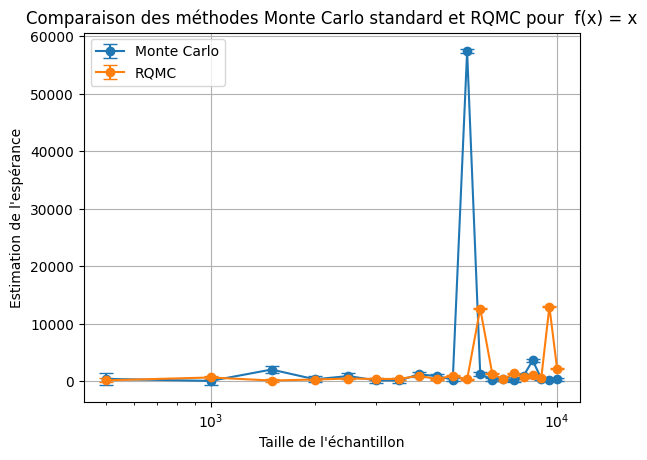

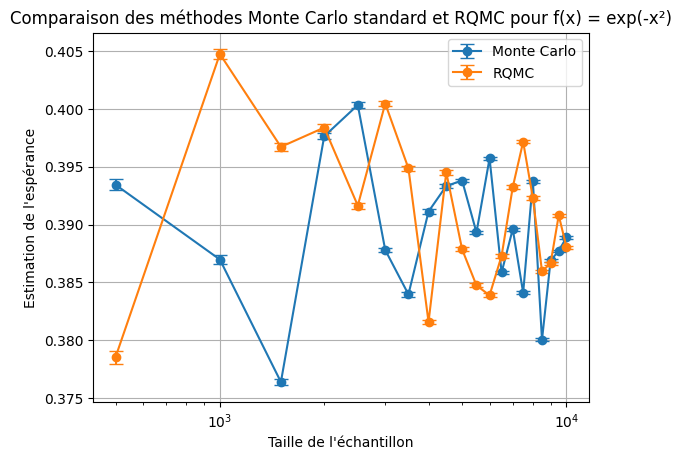

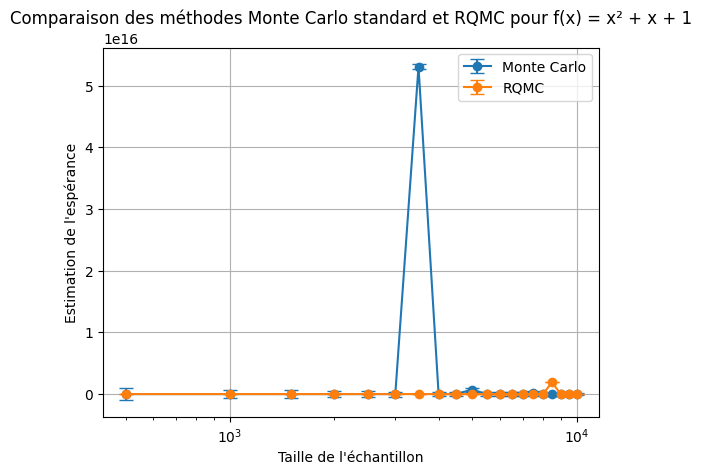

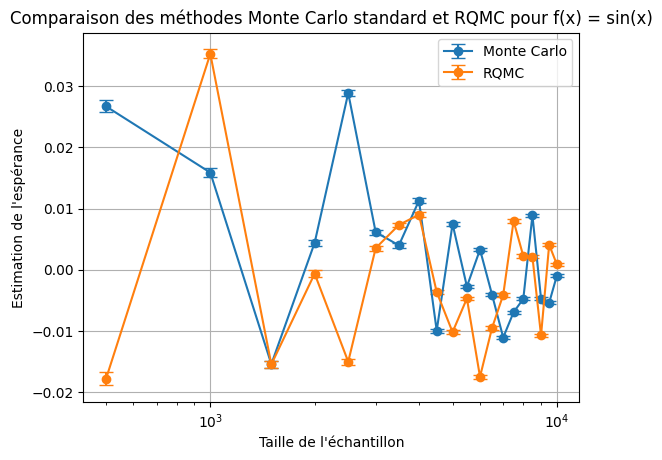

In [178]:
for f in [f1,f2,f3,f4]:
    max_n = 10000
    # Nombre de points à évaluer
    num_points = 20
# Fonctions à évaluer avec leurs noms correspondants
functions = [(f1, ' f(x) = x'), (f2, 'f(x) = exp(-x²)'), (f3, 'f(x) = x² + x + 1'), (f4, 'f(x) = sin(x)')]

# Calcul et tracé des résultats pour chaque fonction
for f, name in functions:
    # Tableaux pour stocker les résultats
    mc_estimates = np.zeros(num_points)
    rqmc_estimates = np.zeros(num_points)
    sample_sizes = np.zeros(num_points)

    # Calcul des estimations pour différentes tailles d'échantillons
    for i in range(num_points):
        n = (i + 1) * (max_n // num_points)
        sample_sizes[i] = n
        mc_estimates[i] = monte_carlo_estimate(f, n, alpha, beta, gamma, delta)
        rqmc_estimates[i] = rqmc_estimate(f, n, alpha, beta, gamma, delta)

    # Calcul des intervalles de confiance
    mc_std_err = np.std(mc_estimates) / np.sqrt(sample_sizes)
    rqmc_std_err = np.std(rqmc_estimates) / np.sqrt(sample_sizes)
    mc_conf_interval = 1.96 * mc_std_err  # Intervalle de confiance à 95%
    rqmc_conf_interval = 1.96 * rqmc_std_err  # Intervalle de confiance à 95%

    # Tracé des résultats
    plt.errorbar(sample_sizes, mc_estimates, yerr=mc_conf_interval, label='Monte Carlo', fmt='o-', capsize=5)
    plt.errorbar(sample_sizes, rqmc_estimates, yerr=rqmc_conf_interval, label='RQMC', fmt='o-', capsize=5)
    plt.xscale('log')
    plt.xlabel('Taille de l\'échantillon')
    plt.ylabel('Estimation de l\'espérance')
    plt.title('Comparaison des méthodes Monte Carlo standard et RQMC pour ' + name)
    plt.legend()
    plt.grid(True)
    plt.show()

D'après les graphiques, on peut tirer certaines conjectures. En effet, la variance de l'estimation de l'espérance par la méthode RQMC est généralement plus faible que celle du Monte Carlo standard. De plus, les deux méthodes convergent vers une valeur similaire, ce qui est attendu avec la loi des grands nombres. Cependant, la convergence avec RQMC semble être plus rapide. 